In [1]:
import time
start_time = time.time()

In [2]:
import logging
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvn

import dcor

from stein_thinning.thinning import thin_gf

import lotka_volterra
from thinning import gaussian_thin, laplace_approximation
import utils.caching
from utils.caching import make_cached_s3
from utils.parallel import get_map_parallel_joblib, parallelise_for_unique
from utils.paths import S3_BUCKET_NAME
from utils.plotting import highlight_points

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
cached = make_cached_s3(S3_BUCKET_NAME)

In [6]:
map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())

In [7]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [8]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_samples(i) -> np.ndarray:
    raise NotImplementedError

In [9]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_thinned_idx(i) -> np.ndarray:
    raise NotImplementedError

In [10]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def validation_hmc_samples(i) -> np.ndarray:
    raise NotImplementedError

In [11]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_4.npy


# Gradient-free Stein thinning

In [12]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [13]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_log_p(i: int) -> np.ndarray:
    # map_parallel cannot be serialised, so needs to be created afresh
    map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())
    return parallelise_for_unique(lotka_volterra.log_target_density, rw_samples[i], map_parallel)

In [14]:
@cached(batch_size=lotka_volterra.n_chains)
def hmc_log_p(i: int) -> np.ndarray:
    # map_parallel cannot be serialised, so needs to be created afresh
    map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())
    return parallelise_for_unique(lotka_volterra.log_target_density, hmc_samples[i], map_parallel)

## Full sample

### Laplace proxy

In [15]:
%%time
laplace_mean, laplace_cov = laplace_approximation(lotka_volterra.log_target_density, np.mean(rw_samples[0], axis=0))

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_0.npy


CPU times: user 383 ms, sys: 35.2 ms, total: 418 ms
Wall time: 698 ms


In [16]:
laplace_mean

array([-0.38253106,  0.29246505, -0.01989892, -0.01793046])

In [17]:
laplace_cov

array([[ 0.00022649,  0.00014983, -0.00022683, -0.00021143],
       [ 0.00014983,  0.00012714, -0.00014055, -0.00012303],
       [-0.00022683, -0.00014055,  0.00023186,  0.0002205 ],
       [-0.00021143, -0.00012303,  0.0002205 ,  0.00022235]])

The method clearly fails in this case:

In [18]:
gaussian_thin(rw_samples[0], rw_log_p[0], laplace_mean, laplace_cov, n_points_thinned)

DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_log_p_0.npy
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/stein_thinning/thinning.py:127: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint32)

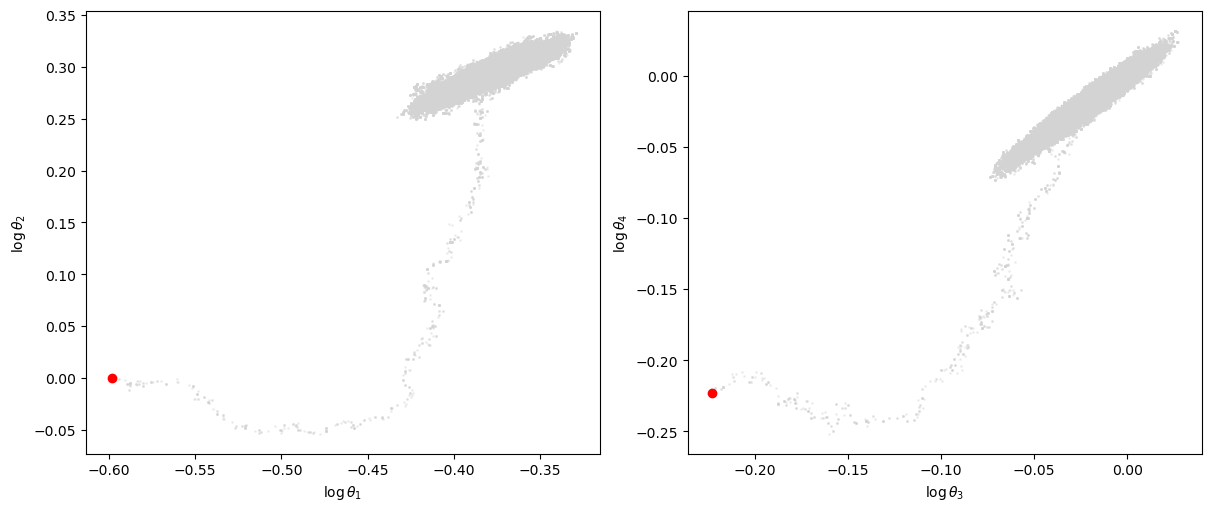

In [19]:
points_to_highlight = [0]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], points_to_highlight, [(0, 1), (2, 3)], axs, var_labels);

We calculate the proxy density at element 0:

In [20]:
log_q = mvn.logpdf(rw_samples[0], mean=laplace_mean, cov=laplace_cov)

In [21]:
log_q[0]

np.float64(-58994.37616137724)

In [22]:
rw_log_p[0][0]

np.float64(-14795.338558498564)

#### Numerical stability of optimisation

Using the default parameters in `scipy.optimize.minimize` results in a failure to find the optimum:

In [23]:
x0 = np.mean(rw_samples[0], axis=0)
res = minimize(lambda x: -lotka_volterra.log_target_density(x), x0)
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -852.0640163222447
        x: [-3.825e-01  2.925e-01 -1.990e-02 -1.793e-02]
      nit: 8
      jac: [ 1.747e-03  1.564e-03  2.144e-03 -3.052e-05]
 hess_inv: [[ 6.045e-04 -2.234e-04 -8.822e-04 -1.157e-03]
            [-2.234e-04  9.307e-05  3.325e-04  4.495e-04]
            [-8.822e-04  3.325e-04  1.293e-03  1.704e-03]
            [-1.157e-03  4.495e-04  1.704e-03  2.264e-03]]
     nfev: 290
     njev: 56

Nelder-Mead succeeds:

In [24]:
x0 = np.mean(rw_samples[0], axis=0)
res = minimize(lambda x: -lotka_volterra.log_target_density(x), x0, method='Nelder-Mead')
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -852.0637592194975
             x: [-3.822e-01  2.926e-01 -2.023e-02 -1.826e-02]
           nit: 36
          nfev: 69
 final_simplex: (array([[-3.822e-01,  2.926e-01, -2.023e-02, -1.826e-02],
                       [-3.823e-01,  2.927e-01, -2.018e-02, -1.823e-02],
                       ...,
                       [-3.822e-01,  2.927e-01, -2.025e-02, -1.824e-02],
                       [-3.823e-01,  2.926e-01, -2.021e-02, -1.825e-02]]), array([-8.521e+02, -8.521e+02, -8.521e+02, -8.521e+02,
                       -8.521e+02]))

However, the Hessian evaluated at the maximum does not appear to be negative definite:

In [25]:
from numdifftools import Hessian

In [26]:
%%time
hess = Hessian(lotka_volterra.log_target_density)(res.x)
hess

CPU times: user 2.4 s, sys: 12 ms, total: 2.41 s
Wall time: 2.55 s


array([[-1196095.221448  ,   329406.57615447, -1108270.83683778,
          106697.01292872],
       [  329406.57615447,  -118085.88891821,   257880.48682018,
           -6315.21069031],
       [-1108270.83683778,   257880.48682018, -1147544.69391788,
          228865.43617875],
       [  106697.01292872,    -6315.21069031,   228865.43617875,
          -97166.87432185]])

In [27]:
np.linalg.eigvals(hess)

array([-2381433.97002698,  -181583.12348197,    22522.02455063,
         -18397.60964763])

In [28]:
def is_positive_definite(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [29]:
is_positive_definite(-hess)

np.False_

### Simple Gaussian proxy

In [30]:
sample_mean = np.mean(rw_samples[0], axis=0)
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d)

In [31]:
sample_mean

array([-0.38261842,  0.29176476, -0.02010969, -0.01824518])

In [32]:
sample_cov

array([[ 2.12987627e-04,  1.62995182e-04, -1.91636668e-04,
        -1.72343118e-04],
       [ 1.62995182e-04,  1.97250184e-04, -1.02375977e-04,
        -6.37599091e-05],
       [-1.91636668e-04, -1.02375977e-04,  2.16947410e-04,
         2.13353024e-04],
       [-1.72343118e-04, -6.37599091e-05,  2.13353024e-04,
         2.30906788e-04]])

In [33]:
idx = gaussian_thin(rw_samples[0], rw_log_p[0], sample_mean, sample_cov, n_points_thinned)
idx

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/stein_thinning/thinning.py:127: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([210376, 427710, 492726,  58196,  59929, 456038, 490046, 308139,
       427710,  12999, 428495, 283038,  80507, 269300, 490046, 377681,
       427710,  59944, 494516, 387883], dtype=uint32)

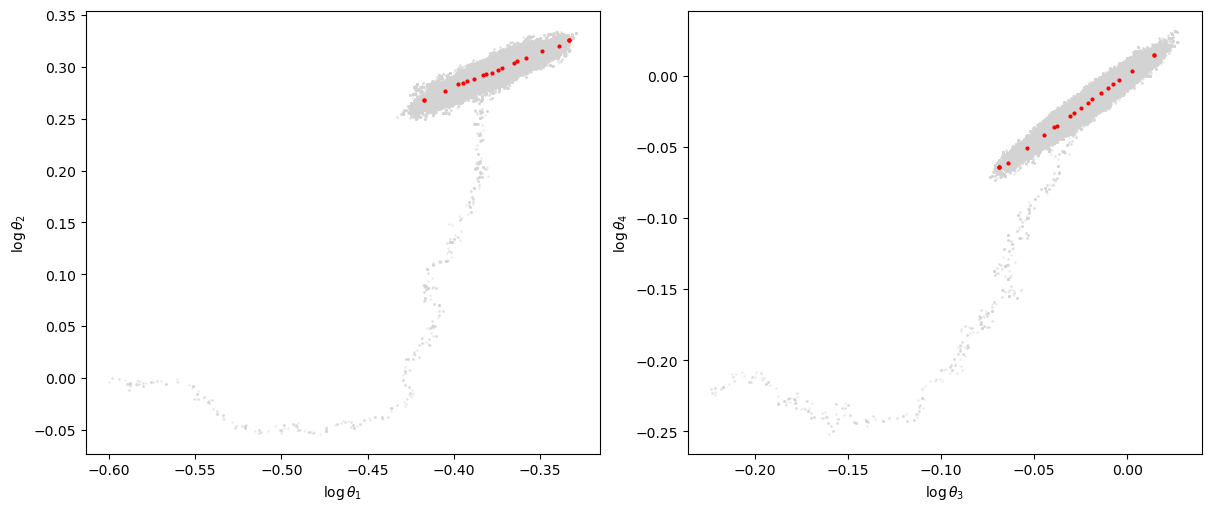

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

In [35]:
log_q = mvn.logpdf(rw_samples[0], mean=sample_mean, cov=sample_cov)
gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(sample_cov), rw_samples[0] - sample_mean)

In [36]:
np.ptp(log_q - rw_log_p[0])

np.float64(12428.9651738708)

In [37]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_gf_simple_gaussian_idx(i) -> np.ndarray:
    sample = rw_samples[i]
    log_p = rw_log_p[i]
    sample_mean = np.mean(sample, axis=0)
    sample_cov = np.cov(sample, rowvar=False, ddof=lotka_volterra.d)
    return gaussian_thin(sample, log_p, sample_mean, sample_cov, n_points_calculate)

In [38]:
%%time
map_parallel(rw_gf_simple_gaussian_idx.get_or_recalculate, range(lotka_volterra.n_chains));

CPU times: user 60.1 ms, sys: 76.2 ms, total: 136 ms
Wall time: 3.62 s


Notebook execution took:

In [39]:
time.time() - start_time

54.72193121910095